# GRN calibration evaluation

## Library import

In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import roc_auc_score
import scanpy as sc

import sklearn
import copy

import anndata as ad
import scvi
from regvelo import REGVELOVI

import mplscience
import seaborn as sns
from matplotlib import pyplot as plt

from rgv_tools import DATA_DIR,FIG_DIR

from itertools import product, permutations
from operator import pos

import copy
from inferelator.postprocessing.model_metrics import RankSummingMetric, RankSummaryPR

/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regve

## General setting

In [2]:
scvi.settings.seed = 0

[rank: 0] Seed set to 0


## Constants

In [3]:
DATASET = "mHSPC"

In [4]:
SAVE_DATA = True
SAVE_FIGURE = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "results").mkdir(parents=True, exist_ok=True)
if SAVE_FIGURE:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

## Define functions

We followed the GRN calibration evaluation workflow provided by PMF-GRN, please check https://github.com/nyu-dl/pmf-grn/blob/main/evaluate_calibration.py

In [5]:
RankSummingMetricCopy = copy.deepcopy(RankSummingMetric)

def get_calibration_score(to_eval, gold_standard, filter_method='overlap',method = "auroc"):
    metrics = RankSummingMetricCopy([to_eval], gold_standard, filter_method)
    
    if method == "auprc":
        data = RankSummaryPR.calculate_precision_recall(metrics.filtered_data)
        auc = RankSummaryPR.calculate_aupr(data)
    elif method == "auroc":
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(metrics.filtered_data["gold_standard"],metrics.filtered_data["combined_confidences"])
        auc = sklearn.metrics.auc(fpr, tpr)
    return auc

## Data loading

In [6]:
adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / "mHSC_ExpressionData.h5ad")

In [7]:
TF = pd.read_csv(DATA_DIR / DATASET / "raw" / "mouse-tfs.csv")
TF = [i[0].upper() + i[1:].lower() for i in TF["TF"].tolist()]

In [8]:
TF = np.array(TF)[[i in adata.var_names for i in TF]]

In [9]:
TF

array(['Ankrd22', 'Ankrd7', 'Arntl2', 'Batf3', 'Bcl11b', 'Bmp6', 'Btg2',
       'Chd7', 'Ciita', 'Cnot6l', 'Creb5', 'Csrp3', 'Ctr9', 'Ebf1',
       'Egr2', 'Esr1', 'Ets1', 'Etv6', 'Eya1', 'Eya2', 'Eya4', 'Fos',
       'Fosb', 'Gata1', 'Gata2', 'Gata3', 'Gfi1', 'Gfi1b', 'Glis3', 'Hlf',
       'Hoxa9', 'Hspb1', 'Id2', 'Id3', 'Ifi204', 'Ikzf1', 'Ikzf3', 'Il10',
       'Irf4', 'Irf8', 'Isl1', 'Klf1', 'Klf6', 'Kpna2', 'Ldb2', 'Lef1',
       'Lmo4', 'Maf', 'Mapk11', 'Mecom', 'Mef2c', 'Meis1', 'Mllt3',
       'Mmp9', 'Myb', 'Myc', 'Mycn', 'Nfatc2', 'Nfia', 'Nfil3', 'Nfkbiz',
       'Nr1h4', 'Pax5', 'Pgr', 'Pou2af1', 'Prdm1', 'Rad54b', 'Rapgef3',
       'Relb', 'Rora', 'Runx1t1', 'Satb1', 'Setbp1', 'Sla2', 'Smarca4',
       'Spib', 'Stat3', 'Stat4', 'Tox2', 'Trib3', 'Trps1', 'Xbp1',
       'Zbtb16', 'Zbtb20', 'Zbtb38', 'Zfp354a'], dtype='<U12')

### Load ground truth (ChIP-seq)

In [10]:
gt = pd.read_csv(DATA_DIR / DATASET / "raw" / "mHSC-ChIP-seq-network.csv")
gt["Gene1"] =  [i[0].upper() + i[1:].lower() for i in gt["Gene1"].tolist()]
gt["Gene2"] =  [i[0].upper() + i[1:].lower() for i in gt["Gene2"].tolist()]
gt = gt.loc[[i in TF for i in gt["Gene1"]],:]
gt = gt.loc[[i in adata.var_names for i in gt["Gene2"]],:]

p_class = pd.DataFrame(0,index = adata.var_names,columns = TF)

for _, row in gt.iterrows():
    reg = row['Gene1']
    tar = row['Gene2']
    if tar in p_class.index and reg in p_class.columns:
        p_class.loc[tar, reg] = 1

## Running GRN to calculate caliberate estimate of error

In [ ]:
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
    
for nrun in range(10):
    vae = REGVELOVI(adata,regulators = TF)
    vae.train()

    vae.save(DATA_DIR / DATASET / "processed" / f"hsc_model_run_{nrun}")

In [13]:
grns = []
for nrun in range(10):
    path = DATA_DIR / DATASET / "processed" / f"hsc_model_run_{nrun}"
    vae = REGVELOVI.load(path, adata)

    w = vae.module.v_encoder.fc1.weight.cpu().detach()
    w = pd.DataFrame(w,index=adata.var_names,columns = adata.var_names)
    w = w.loc[:,TF]
    grns.append(w)

INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/parameter_tuning/caliaberate_error/hsc_model_run
         _0/model.pt already downloaded                                                                            


/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/parameter_tuning/caliaberate_error/hsc_model_run
         _1/model.pt already downloaded                                                                            


/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/parameter_tuning/caliaberate_error/hsc_model_run
         _2/model.pt already downloaded                                                                            


/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/parameter_tuning/caliaberate_error/hsc_model_run
         _3/model.pt already downloaded                                                                            


/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/parameter_tuning/caliaberate_error/hsc_model_run
         _4/model.pt already downloaded                                                                            


/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/parameter_tuning/caliaberate_error/hsc_model_run
         _5/model.pt already downloaded                                                                            


/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/parameter_tuning/caliaberate_error/hsc_model_run
         _6/model.pt already downloaded                                                                            


/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/parameter_tuning/caliaberate_error/hsc_model_run
         _7/model.pt already downloaded                                                                            


/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/parameter_tuning/caliaberate_error/hsc_model_run
         _8/model.pt already downloaded                                                                            


/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/parameter_tuning/caliaberate_error/hsc_model_run
         _9/model.pt already downloaded                                                                            


/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...


In [14]:
stacked = np.stack(grns)
median = np.median(stacked,axis = 0)
epsilon = np.percentile(np.abs(median)[median!=0], 10)
edge_variance = (np.median(np.abs(stacked - median),axis = 0)+epsilon) / (np.abs(median)+epsilon)

In [15]:
edge_variance = pd.DataFrame(edge_variance,index = p_class.index, columns = p_class.columns)
grn = pd.DataFrame(median,index = p_class.index, columns = p_class.columns)

In [16]:
percentile_values = np.percentile(edge_variance, np.arange(1, 11)*10)
auprcs = []
for i in range(2,len(percentile_values)):
    to_eval = copy.deepcopy(np.abs(grn))
    to_eval[edge_variance > percentile_values[i]] = np.nan
    auprcs.append(get_calibration_score(to_eval, p_class, filter_method='overlap',method = "auprc"))

2025-10-25 16:06:43 1 GS: 8940 edges; Confidences: 28250 edges
2025-10-25 16:06:44 1 GS: 8940 edges; Confidences: 37667 edges
2025-10-25 16:06:44 1 GS: 8940 edges; Confidences: 47084 edges
2025-10-25 16:06:44 1 GS: 8940 edges; Confidences: 56501 edges
2025-10-25 16:06:44 1 GS: 8940 edges; Confidences: 65918 edges
2025-10-25 16:06:44 1 GS: 8940 edges; Confidences: 75250 edges
2025-10-25 16:06:44 1 GS: 8940 edges; Confidences: 84667 edges
2025-10-25 16:06:44 1 GS: 8940 edges; Confidences: 94084 edges


In [17]:
auprcs

[0.17072510990303702,
 0.16163773408491552,
 0.154657775559322,
 0.14891162480176293,
 0.14441520241636058,
 0.14058914165962355,
 0.13723783365027428,
 0.1336906127397129]

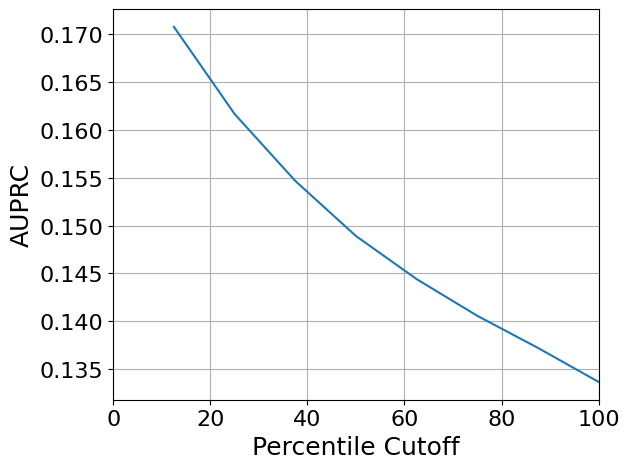

In [18]:
plt.rcParams["svg.fonttype"] = "none"
plt.plot(np.arange(1, len(auprcs)+1) * 100/len(auprcs), np.array(auprcs))
plt.xlim(0, 100)
plt.grid()
plt.xlabel("Percentile Cutoff", fontsize=18)
plt.ylabel("AUPRC", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()

if SAVE_FIGURE:
    plt.savefig(FIG_DIR / DATASET / "GRN_calibration_auprc.svg", format="svg", transparent=True, bbox_inches="tight")

In [19]:
auroc = []
for i in range(2,len(percentile_values)):
    to_eval = copy.deepcopy(np.abs(grn))
    to_eval[edge_variance > percentile_values[i]] = np.nan
    auroc.append(get_calibration_score(to_eval, p_class, filter_method='overlap',method = "auroc"))

2025-10-25 16:06:50 1 GS: 8940 edges; Confidences: 28250 edges
2025-10-25 16:06:50 1 GS: 8940 edges; Confidences: 37667 edges
2025-10-25 16:06:50 1 GS: 8940 edges; Confidences: 47084 edges
2025-10-25 16:06:50 1 GS: 8940 edges; Confidences: 56501 edges
2025-10-25 16:06:50 1 GS: 8940 edges; Confidences: 65918 edges
2025-10-25 16:06:51 1 GS: 8940 edges; Confidences: 75250 edges
2025-10-25 16:06:51 1 GS: 8940 edges; Confidences: 84667 edges
2025-10-25 16:06:51 1 GS: 8940 edges; Confidences: 94084 edges


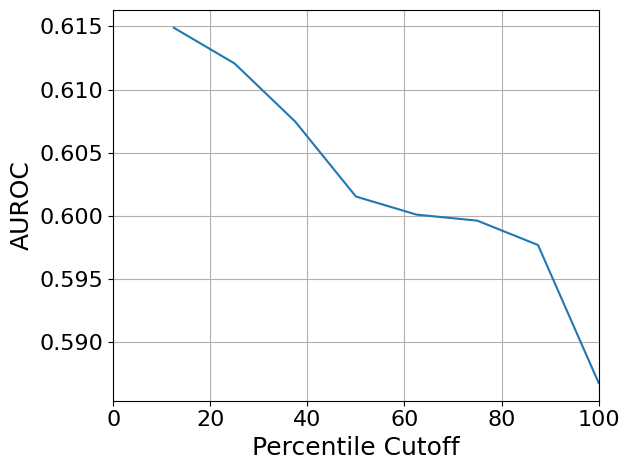

In [20]:
plt.plot(np.arange(1, len(auroc)+1) * 100/len(auroc), auroc)
plt.xlim(0, 100)
plt.grid()
plt.xlabel("Percentile Cutoff", fontsize=18)
plt.ylabel("AUROC", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()

if SAVE_FIGURE:
    plt.savefig(FIG_DIR / DATASET / "GRN_calibration_roc.svg", format="svg", transparent=True, bbox_inches="tight")